In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

from subprocess import check_output

# Any results you write to the current directory are saved as output.
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
data = pd.read_csv('full_data_with_dates.csv')

In [4]:
small_data = data[['Day','Month', 'Year', 'Date', 'Latitude', 'Longitude']]

In [5]:
factor_lat = 0.00898892564 # KMs in 1 degree lat
factor_lon = 0.01424562303 # KMs in 1 degree lon

In [6]:
lat_max = 51.538700 + 4*factor_lat
lat_min = 51.538700 - 4*factor_lat
lon_min = 0.016600 - 4*factor_lon
lon_max = 0.016600 + 4*factor_lon

In [7]:
london = small_data.loc[(small_data['Latitude'] < lat_max)&
                          (small_data['Latitude'] > lat_min)&
                          (small_data['Longitude'] < lon_max)&
                          (small_data['Longitude'] > lon_min)]

In [8]:
olympics = london[((london['Month']==7)|(london['Month']==8))&
                        (london['Year']==2012)]

In [9]:
others = london[~london.isin(olympics)].dropna()

In [10]:
olympics_dist = list(olympics.groupby(['Date']).count().Day)
others_dist = list(others.groupby(['Date']).count().Day)

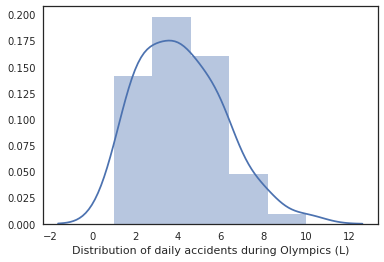

In [22]:
sns.distplot(olympics_dist, bins=5, axlabel='Distribution of daily accidents during Olympics (L)')

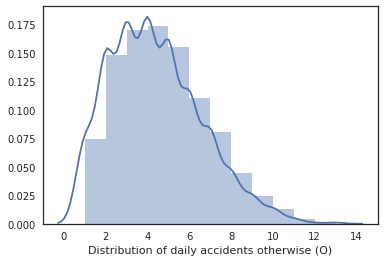

In [23]:
sns.distplot(others_dist, bins=12, axlabel='Distribution of daily accidents otherwise (O)')

Confidence Intervals Test (90% confidence interval test right tailed)

In [30]:
z_score = 1.645
mean_olympics = np.mean(olympics_dist)
mean_others = np.mean(others_dist)
olympics_var = np.var(olympics_dist)
others_var = np.var(others_dist)
ci_max = (mean_olympics - mean_others) + (z_score*np.sqrt(olympics_var/len(olympics_dist)+others_var/len(others_dist)))
ci_min = (mean_olympics - mean_others) - (z_score*np.sqrt(olympics_var+others_var))


In [31]:
ci_max

0.20593809638034566

In [32]:
ci_min

-5.064828624724524

Walds test

In [33]:
statistic = (mean_olympics - mean_others)/(np.sqrt(olympics_var/len(olympics_dist)+others_var/len(others_dist)))
statistic

-0.8501512810659181

For the right tailed statistic, because the observed statistic is less than the value of 1.645, we will accept the null hypothesis.

P-value

In [40]:
p_value = stats.norm.cdf(statistic)
p_value

0.19762049197668313

Since P value is greater than 0.05, hence we accept the null hypothesis

KS test (2 Sample)

In [41]:
stats.ks_2samp(olympics_dist, others_dist)

Ks_2sampResult(statistic=0.06711033139532074, pvalue=0.9495177124270517)

In [45]:
def run_permutation_test(pooled,sizeZ,sizeY,delta):
    np.random.shuffle(pooled)
    starZ = pooled[:sizeZ]
    starY = pooled[-sizeY:]
    return starZ.mean() - starY.mean()
pooled = np.hstack([olympics_dist, others_dist])
delta = mean_olympics - mean_others
numSamples = 10000
estimates = list(map(lambda x: run_permutation_test(pooled,len(olympics_dist),len(others_dist),delta),range(numSamples)))
diffCount = len(np.where(estimates <= delta)[0])
hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_asl_perm

0.7666999999999999

This p value is large, so they come from the same distribution i.e. we accept the NULL Hypothesis